<a href="https://colab.research.google.com/github/earthspecies/open_collaboration_on_audio_classification/blob/master/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys
if 'google.colab' in sys.modules:
  !pip install git+git://github.com/fastai/fastai2.git
  !pip install torchaudio

from fastai2.vision.all import *
import torchaudio

Being able to identify the speaker is believed to be a necessary component of a language.

Can you share a way of working with the audio data? This could be very helpful to researchers who might be very familiar with digital signal processing techniques, but who maybe haven't had such a broad exposure to deep learning. Also, there are probably quite a lot of people across the world (students, hobbyists) who could benefit greatly from your work!

Below I include some starter code to get you going. Would be great if this could turn into a collaborative effort where we could collect in this repository notebooks from contributors showing various ways of working with the data 🙂

To make it even more interesting, I am proposing a particular way of splitting the data into train and validation sets. If you follow this way of splitting in your notebooks, we will be able to compare the results!

The dataset we will use is a collection of macaque coo call recordings collected for the [Distributed acoustic cues for caller identity in macaque vocalization](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4806230/).

You can access the URL of the dataset in `fastai` as follows: `URLs.MACAQUES`. The problem is though that some of the samples were recorded using higher sampling rate. The resampling operation is relatively compute intensive and it is prohibitively costly to be run on colab (though I feel this tells more about the throttling colab does to the vCpus than how expensive the oepration is - locally for me it takes 18 seconds, on colab 20 minutes!). Either way, to accomodate people runnig this code on colab, instead of doing:

```path = untar_data(URLs.MACAQUES)```

We will do

In [2]:
path = untar_data('https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip')

There are 7285 coo calls recorded (stored in wav files) from 8 individuals. They are organized in directories, where a directory groups calls from a single macaque.

In [3]:
path.ls()

(#8) [Path('/root/.fastai/data/macaques_24414Hz/BE'),Path('/root/.fastai/data/macaques_24414Hz/TH'),Path('/root/.fastai/data/macaques_24414Hz/SN'),Path('/root/.fastai/data/macaques_24414Hz/AL'),Path('/root/.fastai/data/macaques_24414Hz/MU'),Path('/root/.fastai/data/macaques_24414Hz/IO'),Path('/root/.fastai/data/macaques_24414Hz/TW'),Path('/root/.fastai/data/macaques_24414Hz/QU')]

Let's listen to one of the calls in our browser!

In [0]:
import pathlib
from IPython.display import Audio

In [5]:
wav_files = get_files(path); wav_files

(#7285) [Path('/root/.fastai/data/macaques_24414Hz/BE/BE214.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE139.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE460.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE405.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE328.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE50.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE224.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE265.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE340.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE436.wav')...]

In [6]:
Audio(filename=wav_files[0])

Did you here the 'coo'? 🙂 Great!

This is what the path to a single recording looks like

In [7]:
wav_files[0]

Path('/root/.fastai/data/macaques_24414Hz/BE/BE214.wav')

This recording comes from an individual codenamed 'MU'. We can grab that information from the path as follows:

In [8]:
wav_files[0].parent.stem

'BE'

Let's read all of the data and see what else we can learn.

In [0]:
import librosa # the librosa library makes it very convenient to work with audio files in Python

In [10]:
%%time
target_rate=24414
audio, names = L(), L()

for fp in wav_files:
    x, rate = torchaudio.load_wav(fp)
    if rate != target_rate: 
      x = torchaudio.transforms.Resample(orig_freq=rate, new_freq=24414, resampling_method='sinc_interpolation')(x)
    names.append(fp.parent.stem)
    audio.append(x[0] / 32767)

CPU times: user 1.32 s, sys: 403 ms, total: 1.72 s
Wall time: 1.76 s


The recording of a sound is nothing more than samples of the air pressure taken by the microphone some number of times (sampling rate) per second. All this gets stored in an array. I've created a bit of a primer on this [here](https://github.com/earthspecies/from_zero_to_DSP), if you would like to learn more.

In [11]:
audio[100]

tensor([-0.0012, -0.0017, -0.0022,  ..., -0.0010, -0.0015, -0.0020])

We can listen to the values in the array!

In [12]:
Audio(audio[100], rate=rate)

Let's look at the duration of calls by indiviual.

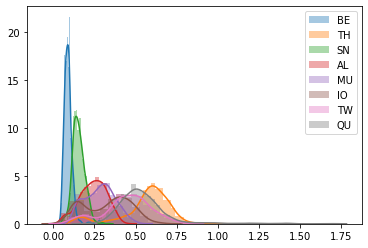

In [13]:
import seaborn as sns

durations = audio.map(len).map(lambda x: x / rate)

for name in names.unique():
    mask = names.map(lambda x: x == name)
    sns.distplot(durations[mask], label=name)
plt.legend();

We see that the calls are of varying length (additionaly, some macaques have a preference for longer calls and other for shorter ones!). This is something we will have to address as we prepare the data for our deep learning model.

Let us build our dataloaders using the `DataBlock` api! There are several pieces we will have to tell the `DataBlock` api how to do.

* how to get all the items from the dataset
* how to label the items
* how to read in the items before passing them to the model

Getting all the items is going to be easy - the starting point for our items will be the paths pointing to our files. We already know how obtan this using the `get_files` function provided by fastai.

In [14]:
get_files(path)

(#7285) [Path('/root/.fastai/data/macaques_24414Hz/BE/BE214.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE139.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE460.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE405.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE328.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE50.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE224.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE265.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE340.wav'),Path('/root/.fastai/data/macaques_24414Hz/BE/BE436.wav')...]

Going from an `item` (a path in our case) to a label is going to be straightforward as well. We already saw how can go about this above

In [15]:
wav_files[0].parent.stem

'BE'

We also already know how to read in an audio file as a numpy array. But how do we go from this representation to something that we could train our model on?

We could build a model straight on the array, it would be very interesting to see how a model like that could perform.

There is also another alternative. We could represent our audio as an image and train a regular CNN classifier on it! For many problems presenting your data as an image before feeding it to a model is a state of the art approach.

In the case of audio, it seems this approach can work very well for [some problems](https://ai.googleblog.com/2018/10/acoustic-detection-of-humpback-whales.html), though it also has [some limitations](https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd).

Devil is in the details - how we train our model, how we prepare the datasets, how we go from audio to an image, all will play a role in the results we get. This is by no means a solved problem - any results you could show through your work could potentially be very useful.

Here is one way we could go about preparing our data.

We can use torchaudio as before to read it in.

In [0]:
x, rate = torchaudio.load_wav(fp)
if rate != target_rate: 
  x = torchaudio.transforms.Resample(orig_freq=rate, new_freq=24414, resampling_method='sinc_interpolation')(x)
x = x[0] / 32767
x = x.numpy()

And then we can represent the audio as a spectrogram.

In [17]:
spec = librosa.feature.melspectrogram(x, sr=rate, n_fft=1024, hop_length=140); spec

array([[5.26159888e-04, 3.56715541e-04, 9.10425499e-05, ...,
        2.40869175e-06, 2.14519967e-05, 6.53447276e-05],
       [5.99315195e-04, 4.05943662e-04, 1.00524894e-04, ...,
        1.39853876e-06, 1.34161870e-05, 4.96851700e-05],
       [7.15164405e-04, 5.27181224e-04, 2.21953537e-04, ...,
        6.56982272e-06, 2.12046531e-05, 6.39668644e-05],
       ...,
       [1.09259643e-08, 7.81140137e-09, 2.91970201e-09, ...,
        1.16049898e-09, 1.69081688e-09, 3.15328225e-09],
       [1.07597443e-08, 7.79395641e-09, 3.27026995e-09, ...,
        9.46175099e-10, 1.87392320e-09, 3.72283917e-09],
       [1.56648526e-08, 1.09981491e-08, 3.68280777e-09, ...,
        1.28728073e-09, 2.41403028e-09, 4.94840593e-09]])

A spectrogram is a visualization of sound where the y axis corresponds to frequencies and the x axis to samples. The resultant image is a decomposition of audio into frequencies that the signal consists of at any given point in time.

This is what our spectrogram would look like.

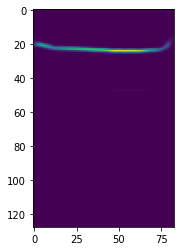

In [18]:
plt.imshow(spec)

We still have a problem though. We know how to go from audio to an image, but our input arrays are of various length! To make it a little bit easier for our model, let's bring them all to the same size, say one corresponding to the first 0.75 seconds.

In [0]:
num_samples = int(0.75 * rate)

Librosa to the rescue as it provides a very handy utility!

In [0]:
x = librosa.util.fix_length(x, num_samples)
spec = librosa.feature.melspectrogram(x, sr=rate, n_fft=1024, hop_length=140)

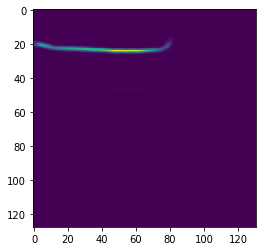

In [21]:
plt.imshow(spec)

Let's pull all of this together. We get our items like this

In [0]:
def get_items(path): return get_files(path)

To get our labels from the path we do this

In [0]:
def get_y(path): return path.parent.stem

And to get our image (in the form of a numpy array) from a path we do this

In [0]:
def get_x(path, target_rate=24414, num_samples=18310):
    x, rate = torchaudio.load_wav(path)
    if rate != target_rate: 
      x = torchaudio.transforms.Resample(orig_freq=rate, new_freq=24414, resampling_method='sinc_interpolation')(x)
    x = x[0] / 32767
    x = x.numpy()
    x = librosa.util.fix_length(x, num_samples)
    spec = librosa.feature.melspectrogram(x, sr=rate, n_fft=1024, hop_length=140)
    spec = spec / spec.max() * 255 # we want the range of values for our data to be [0, 255]
                                   # this way fastai internally will be able to represent it as an image using PIL
    return spec.astype(np.uint8)

Internally, `ImageBlock` will be use `Image.fromarray` to create our image. Let us see if this will work with the data our get_x returns

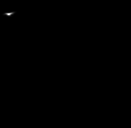

In [25]:
Image.fromarray(get_x(wav_files[0]).astype(np.uint8))

voila! Now let's group all of this using the DataBlock API.

In [0]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(seed=42))

The only thing that we added here is the splitter. It will split our data reserving 20% for validation.

Please remember to pass in the seed! This way we can keep the split consistent between experiments and will be able to compare various approaches.

We can now create dataloaders based on the `DataBlock` we created above.

In [0]:
dls = db.dataloaders(path, num_workers=2)

To make sure everything worked, let's take a look at a batch of data.

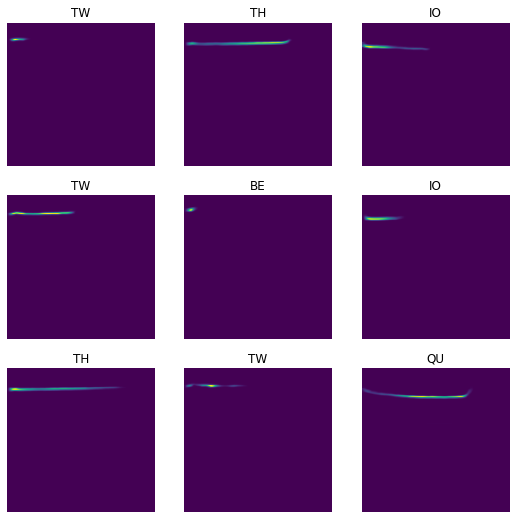

In [28]:
dls.show_batch()

Time to create and train a model!

In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.674175,0.327306,0.087852,01:28


epoch,train_loss,valid_loss,error_rate,time
0,0.307324,0.209452,0.063143,01:28


A 6.3% error rate! Let's see how we are doing across classes

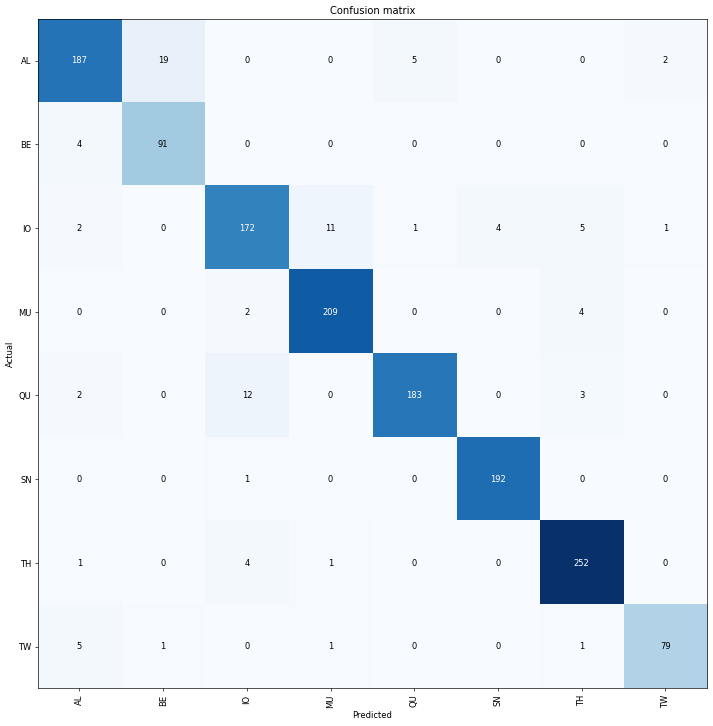

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Overal, the performance is good. But can you do better? Can you achieve an overal better result? Can you share an interesting way of working with the data? What other models than a CNN can you train?

Please make sure to create a pull request with your work so that others can learn from you! 